# <center>Enron Dataset Network Analysis

# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option("display.max_column", None)
pd.set_option("display.max_row", 50)

# EDA

In [2]:
df = pd.read_csv("data/emails.csv")

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
df.shape

(517401, 2)

As we can see our dataset has more than **half a million** rows

In [5]:
df.message[0]

"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n "

We can also observe that our text split with **"\n"** 

## Sampling

Due to the sheer size of the dataset (~1.4gb), we will only work with a random sample of 300 emails, which would be more than enough for the purposes of our analysis

In [6]:
df_sample = df.sample(n = 300, random_state = 0)

In [31]:
#Export the sample dataframe
df_sample.to_csv("data/df_sample.csv")

#### Import the sample dataframe if you don't need the whole dataset


In [33]:
# Import the sample dataframe if you don't need the whole dataset
df_sample=pd.read_csv("data/df_sample.csv", index_col="Unnamed: 0")

,file,message,clean_message,date,sender_email,recipient_email,subject,cc,bcc,body,all_recipient_emails,num_recipient
510816,williams-w3/schedule_crawler/1387.,Message-ID: <20978984.1075839990072.JavaMail.e...,['Message-ID: <20978984.1075839990072.JavaMail...,13 Dec 2001,['pete.davis@enron.com'],['pete.davis@enron.com'],"['Start', 'Date:', 'HourAhead', 'hour:']","['albert.meyers@enron.com', 'bill.williams@enr...","['albert.meyers@enron.com', 'bill.williams@enr...",Date: 12/13/01; HourAhead hour: 5; No ancilla...,"['pete.davis@enron.com', 'albert.meyers@enron....",19
346872,nemec-g/all_documents/5431.,Message-ID: <8987828.1075842774735.JavaMail.ev...,['Message-ID: <8987828.1075842774735.JavaMail....,20 Mar 2001,['tyrell.harrison@enron.com'],['gerald.nemec@enron.com'],"['Executed', 'letter', 'agreements']",['barry.tycholiz@enron.com'],['barry.tycholiz@enron.com'],GeraldBarry should have the executed letter ag...,"['gerald.nemec@enron.com', 'barry.tycholiz@enr...",3
158351,hain-m/all_documents/842.,Message-ID: <30686869.1075860369073.JavaMail.e...,['Message-ID: <30686869.1075860369073.JavaMail...,15 Mar 2001,['rcarroll@bracepatt.com'],"['cyoder@enron.com', 'jsteffe@enron.com', 'rsa...","['Interventions', 'Tuscon', 'Complaint', 'Proc...","['acomnes@enron.com', 'jhartso@enron.com', 'ma...","['acomnes@enron.com', 'jhartso@enron.com', 'ma...",Just a reminder that interventions and comment...,"['cyoder@enron.com', 'jsteffe@enron.com', 'rsa...",12
351661,nemec-g/notes_inbox/2544.,Message-ID: <4155293.1075842841039.JavaMail.ev...,['Message-ID: <4155293.1075842841039.JavaMail....,3 Jan 2001,['dwight.beach@enron.com'],['gerald.nemec@enron.com'],"['GROUND', 'LEASE']",NaN,NaN,"I think that these are current, but you might ...",['gerald.nemec@enron.com'],1
20325,baughman-d/power/legal_agreements/96.,Message-ID: <12670521.1075862605089.JavaMail.e...,['Message-ID: <12670521.1075862605089.JavaMail...,26 Sep 2001,['l..denton@enron.com'],"['kysa.alport@enron.com', 'w..white@enron.com'...","['IDACORP', 'Energy,']",NaN,NaN,"Idaho Power Company, dba IdaCorp Energy, the u...","['kysa.alport@enron.com', 'w..white@enron.com'...",176
...,...,...,...,...,...,...,...,...,...,...,...,...
394114,sanders-r/all_documents/3664.,Message-ID: <28789105.1075860511195.JavaMail.e...,['Message-ID: <28789105.1075860511195.JavaMail...,12 Oct 1999,['dab@sprintmail.com'],"['skusin@susmangodfrey.com', 'khyatt@enron.com...","['Fort', 'James', 'Corp..Kalamazaoo', 'Details']",NaN,NaN,"Stuart,Please find detailed information on the...","['skusin@susmangodfrey.com', 'khyatt@enron.com...",3
205937,kaminski-v/all_documents/3569.,Message-ID: <30921964.1075856270146.JavaMail.e...,['Message-ID: <30921964.1075856270146.JavaMail...,27 Oct 2000,['vince.kaminski@enron.com'],['david.port@enron.com'],"['EWRM', 'outline']",NaN,NaN,"David,This is the outline of the EWRM project....",['david.port@enron.com'],1
446328,skilling-j/sent/409.,Message-ID: <13663006.1075845519045.JavaMail.e...,['Message-ID: <13663006.1075845519045.JavaMail...,23 Mar 2001,['joannie.williamson@enron.com'],['jlfreeh@parkcity.net'],"[""President's"", 'Forum', 'Houston']",NaN,NaN,"Dear Mr. Freeh,Thank you for the invitation, h...",['jlfreeh@parkcity.net'],1
372166,rodrique-r/_sent_mail/440.,Message-ID: <18562828.1075858377482.JavaMail.e...,['Message-ID: <18562828.1075858377482.JavaMail...,27 Nov 2000,['robin.rodrigue@enron.com'],['gabriel.monroy@enron.com'],['Aleluya'],NaN,NaN,Try not to pester you new associate to death w...,['gabriel.monroy@enron.com'],1


# Data cleaning

So Next, we are going to create functions for:

- Spliting the emails 
- Extract meaningful text from them.
- Cleaning the extracted text

In [8]:
def split_text(text, match):
    text = re.sub(r"\n\t", "", text)
    return re.split(match, text)

We then store the new split text into a new column

In [9]:
df_sample["clean_message"] = df_sample.message.apply(lambda x : split_text(x, "\n"))
df_sample.head()

,file,message,clean_message
510816,williams-w3/schedule_crawler/1387.,Message-ID: <20978984.1075839990072.JavaMail.e...,[Message-ID: <20978984.1075839990072.JavaMail....
346872,nemec-g/all_documents/5431.,Message-ID: <8987828.1075842774735.JavaMail.ev...,[Message-ID: <8987828.1075842774735.JavaMail.e...
158351,hain-m/all_documents/842.,Message-ID: <30686869.1075860369073.JavaMail.e...,[Message-ID: <30686869.1075860369073.JavaMail....
351661,nemec-g/notes_inbox/2544.,Message-ID: <4155293.1075842841039.JavaMail.ev...,[Message-ID: <4155293.1075842841039.JavaMail.e...
20325,baughman-d/power/legal_agreements/96.,Message-ID: <12670521.1075862605089.JavaMail.e...,[Message-ID: <12670521.1075862605089.JavaMail....


In [13]:
df_sample.clean_message.values[0]

['Message-ID: <20978984.1075839990072.JavaMail.evans@thyme>',
 'Date: Thu, 13 Dec 2001 06:37:39 -0800 (PST)',
 'From: pete.davis@enron.com',
 'To: pete.davis@enron.com',
 'Subject: Start Date: 12/13/01; HourAhead hour: 5;',
 'Cc: albert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, geir.solberg@enron.com, john.anderson@enron.com, mark.guzman@enron.com, michael.mier@enron.com, pete.davis@enron.com, ryan.slinger@enron.com',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'Bcc: albert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, geir.solberg@enron.com, john.anderson@enron.com, mark.guzman@enron.com, michael.mier@enron.com, pete.davis@enron.com, ryan.slinger@enron.com',
 'X-From: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>',
 'X-To: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>',
 'X-cc: Meyers, Albert </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BMEYERS>, Williams III, Bill </O=ENRON/OU=

We can see out email is now split into a list containing multiple elements, we will go ahead and extract the meaningful text from these lists, such as "sender email", "recipient email" ... etc

In [14]:
def extract_body(text, substr):	
    result = re.split(substr, text)[-1]
    result = re.sub(r"([\n-])", "", result)
    return result

In [15]:
df_sample["date"] = df_sample.clean_message.apply(lambda x : x[1])
df_sample["sender_email"] = df_sample.clean_message.apply(lambda x : x[2])
df_sample["recipient_email"] = df_sample.clean_message.apply(lambda x : x[3])
df_sample["subject"] = df_sample.clean_message.apply(lambda x : x[4])
df_sample["cc"] = df_sample.clean_message.apply(lambda x : x[5])
df_sample["bcc"] = df_sample.clean_message.apply(lambda x : x[9])
df_sample["body"] = df_sample.message.apply(lambda x : extract_body(x, r"X-FileName: [\w]*[\s]*[(Non\-Privileged).pst]*[\w-]*[.nsf]*").strip())

In [16]:
df_sample.head(3)

,file,message,clean_message,date,sender_email,recipient_email,subject,cc,bcc,body
510816,williams-w3/schedule_crawler/1387.,Message-ID: <20978984.1075839990072.JavaMail.e...,[Message-ID: <20978984.1075839990072.JavaMail....,"Date: Thu, 13 Dec 2001 06:37:39 -0800 (PST)",From: pete.davis@enron.com,To: pete.davis@enron.com,Subject: Start Date: 12/13/01; HourAhead hour: 5;,"Cc: albert.meyers@enron.com, bill.williams@enr...","Bcc: albert.meyers@enron.com, bill.williams@en...",Date: 12/13/01; HourAhead hour: 5; No ancilla...
346872,nemec-g/all_documents/5431.,Message-ID: <8987828.1075842774735.JavaMail.ev...,[Message-ID: <8987828.1075842774735.JavaMail.e...,"Date: Tue, 20 Mar 2001 00:12:00 -0800 (PST)",From: tyrell.harrison@enron.com,To: gerald.nemec@enron.com,Subject: Executed letter agreements,Cc: barry.tycholiz@enron.com,Bcc: barry.tycholiz@enron.com,GeraldBarry should have the executed letter ag...
158351,hain-m/all_documents/842.,Message-ID: <30686869.1075860369073.JavaMail.e...,[Message-ID: <30686869.1075860369073.JavaMail....,"Date: Thu, 15 Mar 2001 01:30:00 -0800 (PST)",From: rcarroll@bracepatt.com,"To: cyoder@enron.com, jsteffe@enron.com, rsand...",Subject: Interventions in Tuscon Complaint Pro...,"Cc: acomnes@enron.com, jhartso@enron.com, mary...","Bcc: acomnes@enron.com, jhartso@enron.com, mar...",Just a reminder that interventions and comment...


A lot of work, but we still aren't finished with the data cleaning process

The sender and recepient emails still need some cleaning, like removing the "From: " and "To: ", as well as extracting the subject.

In [17]:
def extract_emails(text, substr):
    result = re.findall("[^\s]+@[\w]+.[\w]+", str(text))
    if substr not in text:
        result = ""
    return result

def extract_subject(text):

    list_of_words = re.split("\s", text)
    words_to_drop = ["Subject:","re:","Re:","RE:","fw:","Fw:", "FW:"]

    desired_words = []
    for word in list_of_words:
        if word not in words_to_drop:
            desired_words.append(word)

    r = re.compile("[\w]{3,}")
    final_list = list(filter(r.match, desired_words))

    return final_list

In [18]:
#Trim and clean date
df_sample.loc[:,"date"] = df_sample.loc[:,"date"].apply(lambda x : x[10:22])

#- Trim and clean sender and recipient email
df_sample.loc[:,"sender_email"] = df_sample.loc[:,"sender_email"].apply(lambda x : extract_emails(x, "From: "))
df_sample.loc[:,"recipient_email"] = df_sample.loc[:,"recipient_email"].apply(lambda x : extract_emails(x, "To: "))
df_sample.loc[:,"cc"] = df.loc[:,"cc"].apply(lambda x : extract_emails(x, "Cc: "))
df_sample.loc[:,"bcc"] = df.loc[:,"bcc"].apply(lambda x : extract_emails(x, "Bcc: "))

#- Trim and clean subject
df_sample.loc[:,"subject"] = df_sample.loc[:,"subject"].apply(lambda x : extract_subject(x))

We also need to store all recepients emails -- **ie: the recepients, the CCs and BCCs** -- in a column, as well their number 

In [19]:
df_sample["all_recipient_emails"] = df_sample.apply(lambda x : list(x["recipient_email"]) + list(x["cc"]) + list(x["bcc"]), axis = 1)

df_sample["num_recipient"] = df_sample.recipient_email.apply(lambda x : len(x)) + df_sample.cc.apply(lambda x : len(x)) + \
                                df_sample.bcc.apply(lambda x : len(x))

In [20]:
#Checking for emails without recepients
df_sample[df_sample["num_recipient"]==0].shape

(8, 12)

We have some emails that don't have a receptient, these are probably drafts that were never sent, so we'll not take them into consideration

In [21]:
df_sample=df_sample[df_sample["num_recipient"]!=0]

To further deepen our analysis we'll also extract information about the entity (corporation) that these mails belong to.

In [22]:
def extract_entity(text):
    string = ""
    for i in text:
        string = string + " " + i

    list_of_emails = list(re.findall(r"@[\w]+", string))
    result = []
    for item in list_of_emails:
        result.append(item[1:])

    return set(result)

In [23]:
#- extract sender and recipient entity info
df_sample["sender_entity"]    = df_sample.loc[:,"sender_email"].apply(lambda x : extract_entity(x))
df_sample["recipient_entity_to"] = df_sample.loc[:,"recipient_email"].apply(lambda x : extract_entity(x))
df_sample["recipient_entity_cc"] = df_sample.loc[:,"cc" ].apply(lambda x : extract_entity(x))
df_sample["recipient_entity_bcc"] = df_sample.loc[:,"bcc"].apply(lambda x : extract_entity(x))

df_sample["all_recipient_entities"] = df_sample.apply(lambda x : \
                                                 x["recipient_entity_to" ] | \
                                                 x["recipient_entity_cc" ] | \
                                                 x["recipient_entity_bcc"], axis = 1)

df_sample["sender_entity"] = df_sample.sender_entity.apply(lambda x : list(x))

df_sample["all_recipient_entities"] = df_sample.all_recipient_entities.apply(lambda x : list(x))

C:\Users\Azus\AppData\Local\Temp\ipykernel_21164\3490218573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sender_entity"]    = df.loc[:,"sender_email"].apply(lambda x : extract_entity(x))
C:\Users\Azus\AppData\Local\Temp\ipykernel_21164\3490218573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recipient_entity_to"] = df.loc[:,"recipient_email"].apply(lambda x : extract_entity(x))
C:\Users\Azus\AppData\Local\Temp\ipykernel_21164\3490218573.py:4: SettingWithCopyWarning: 
A value is trying t

Since `all_recipient_emails` contain multiple emails, to construct our network **graph** we must split them into multiple rows

In [24]:
def split_into_rows(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.len()),"receive": list(chain.from_iterable(df_col2))})
    result_df.send = result_df.send.apply(lambda x : x[0] if len(x) >0 else '')
    return result_df

In [25]:
df_emails = split_into_rows(df_sample.sender_email, df_sample.all_recipient_emails)

We'll also do the same thing for entites

In [26]:
df_entities = split_into_rows(df_sample.sender_entity, df_sample.all_recipient_entities)

# Visualise

Now we'll only visualise part of the network (graph), due to the large size of it.

So we'll take a random sample of 300 emails, an try to visualize the network

First, the **emails graph**

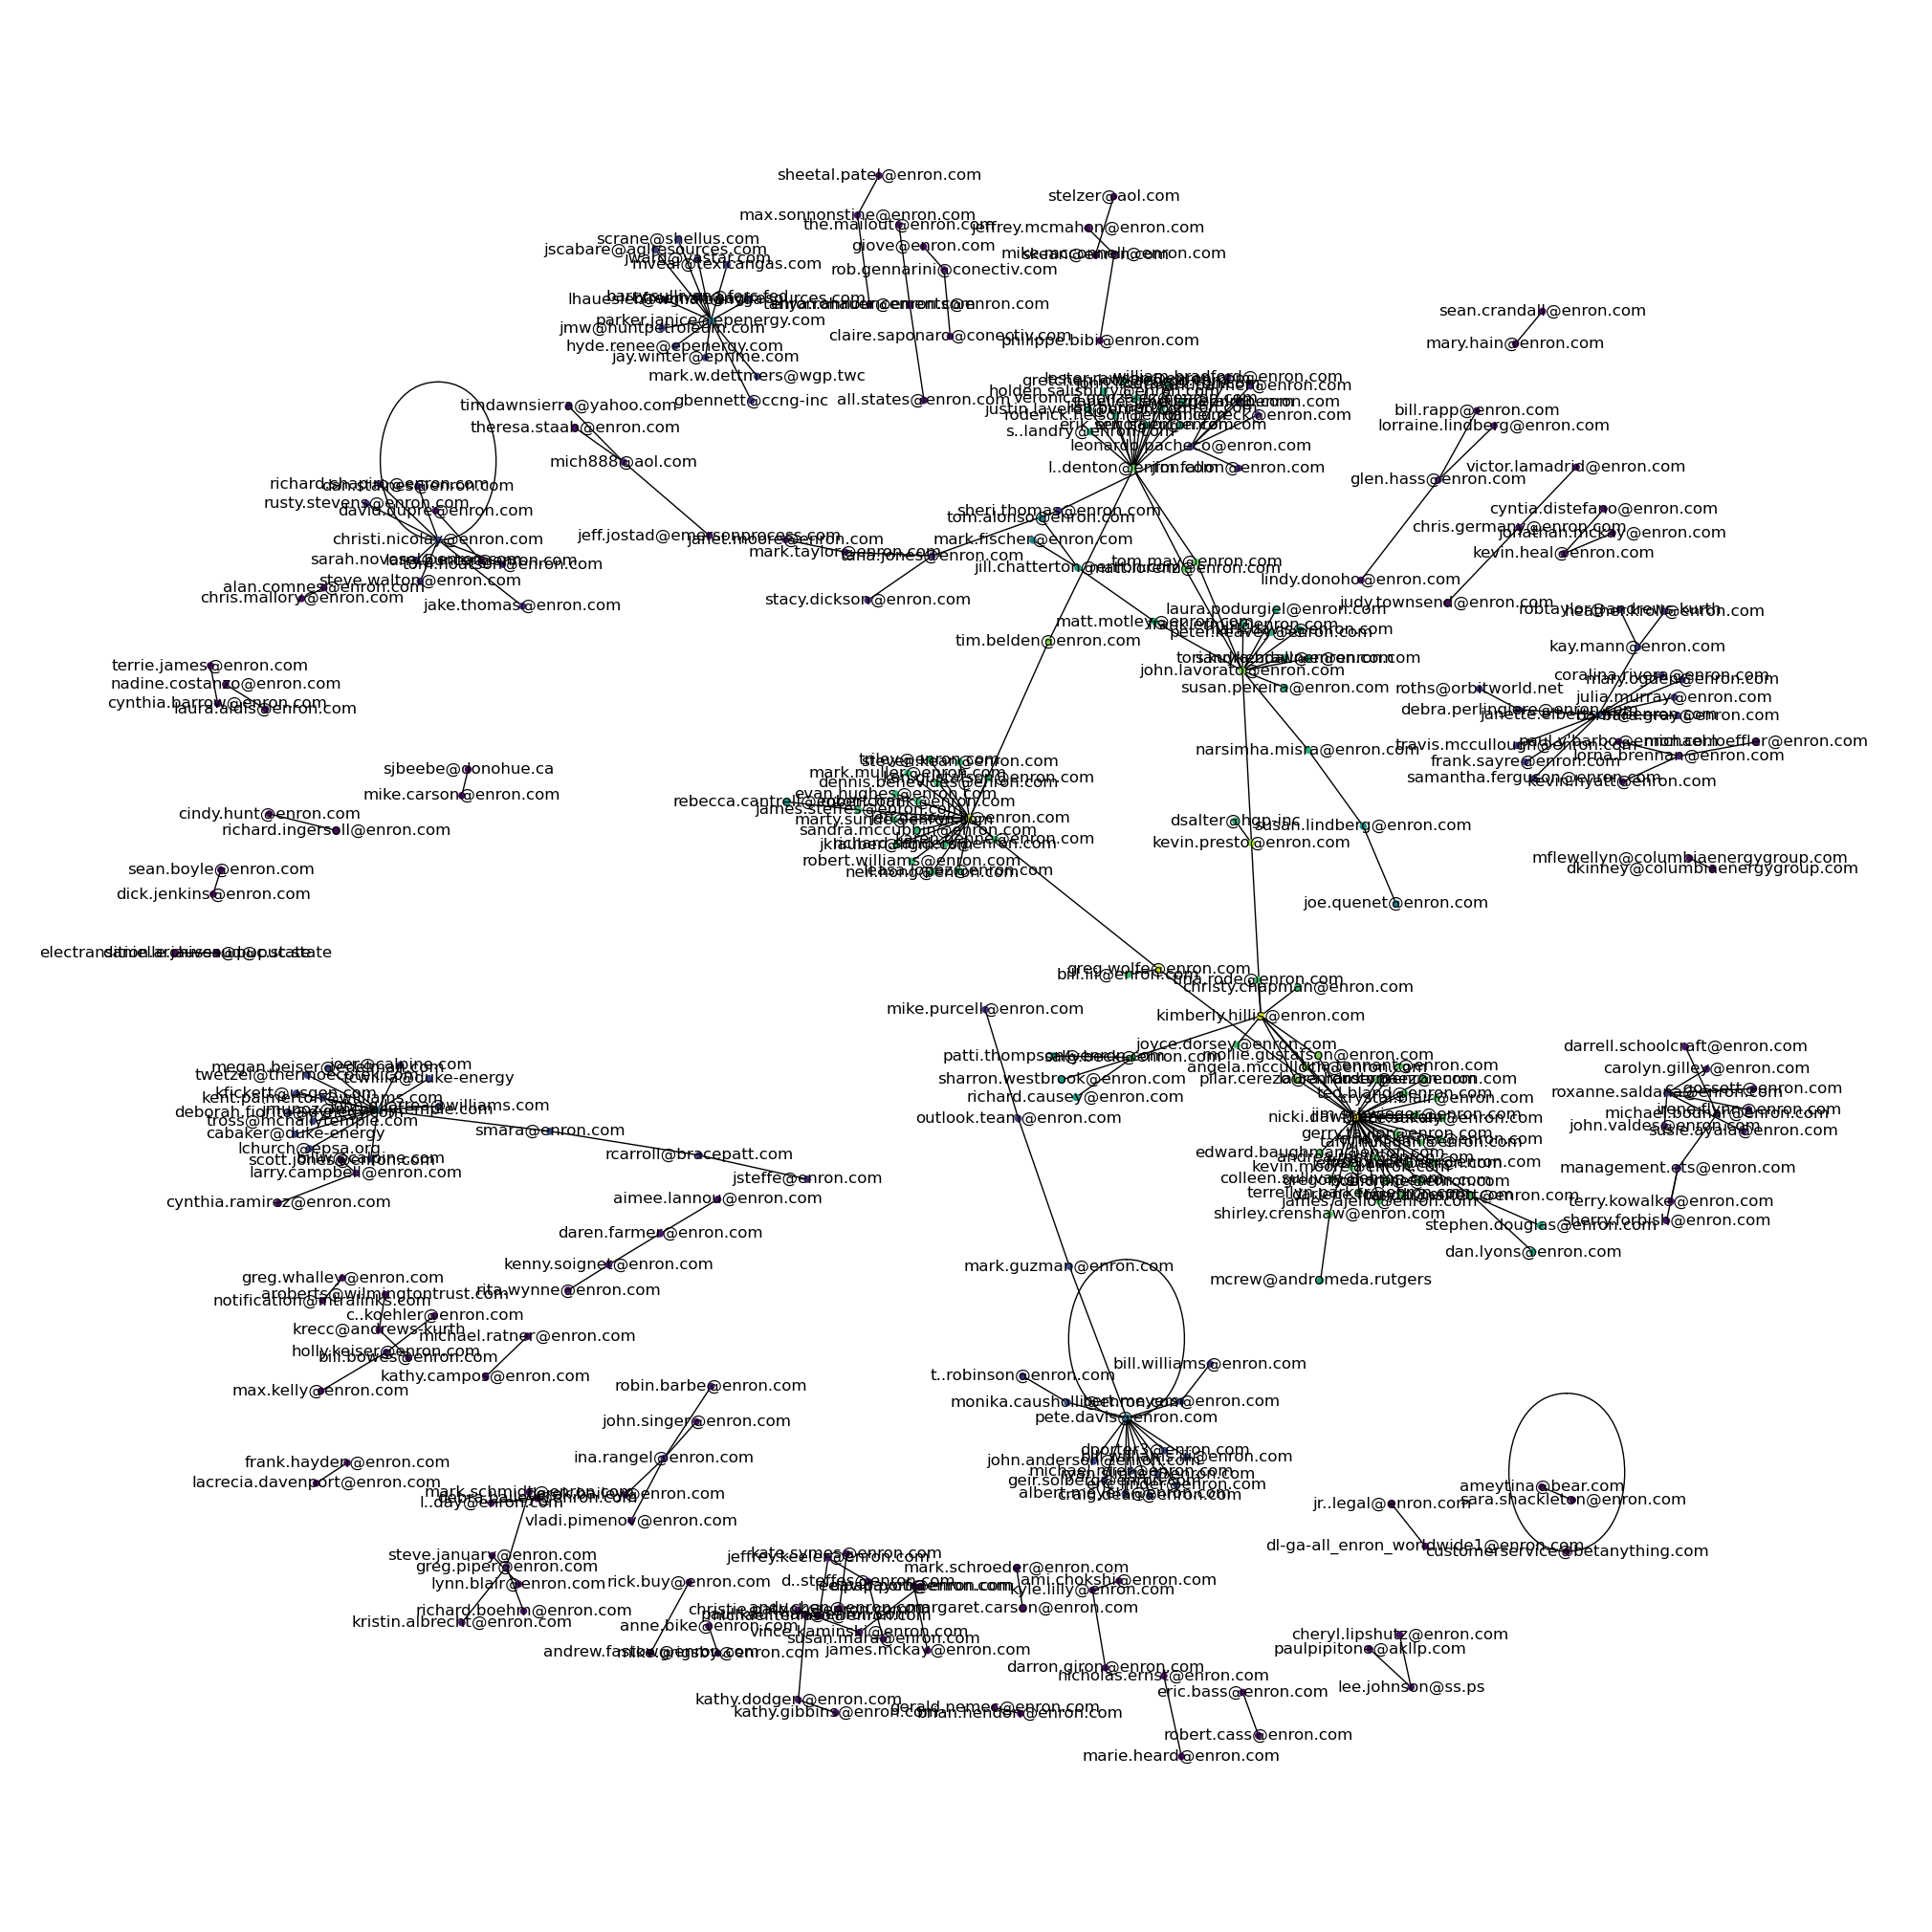

In [27]:
G1 = nx.from_pandas_edgelist(df_emails.sample(round(0.1*len(df_emails)), random_state = 0), "send", "receive")

closeness_G1 = nx.closeness_centrality(G1)
closeness_G1 = list(closeness_G1.values())

plt.figure(figsize = (20,20))

pos1 = nx.spring_layout(G1, k=.1)
nx.draw(G1, pos1, node_size = 20, node_color = closeness_G1, with_labels = True)
plt.show()

And now for **entities (corporations)**

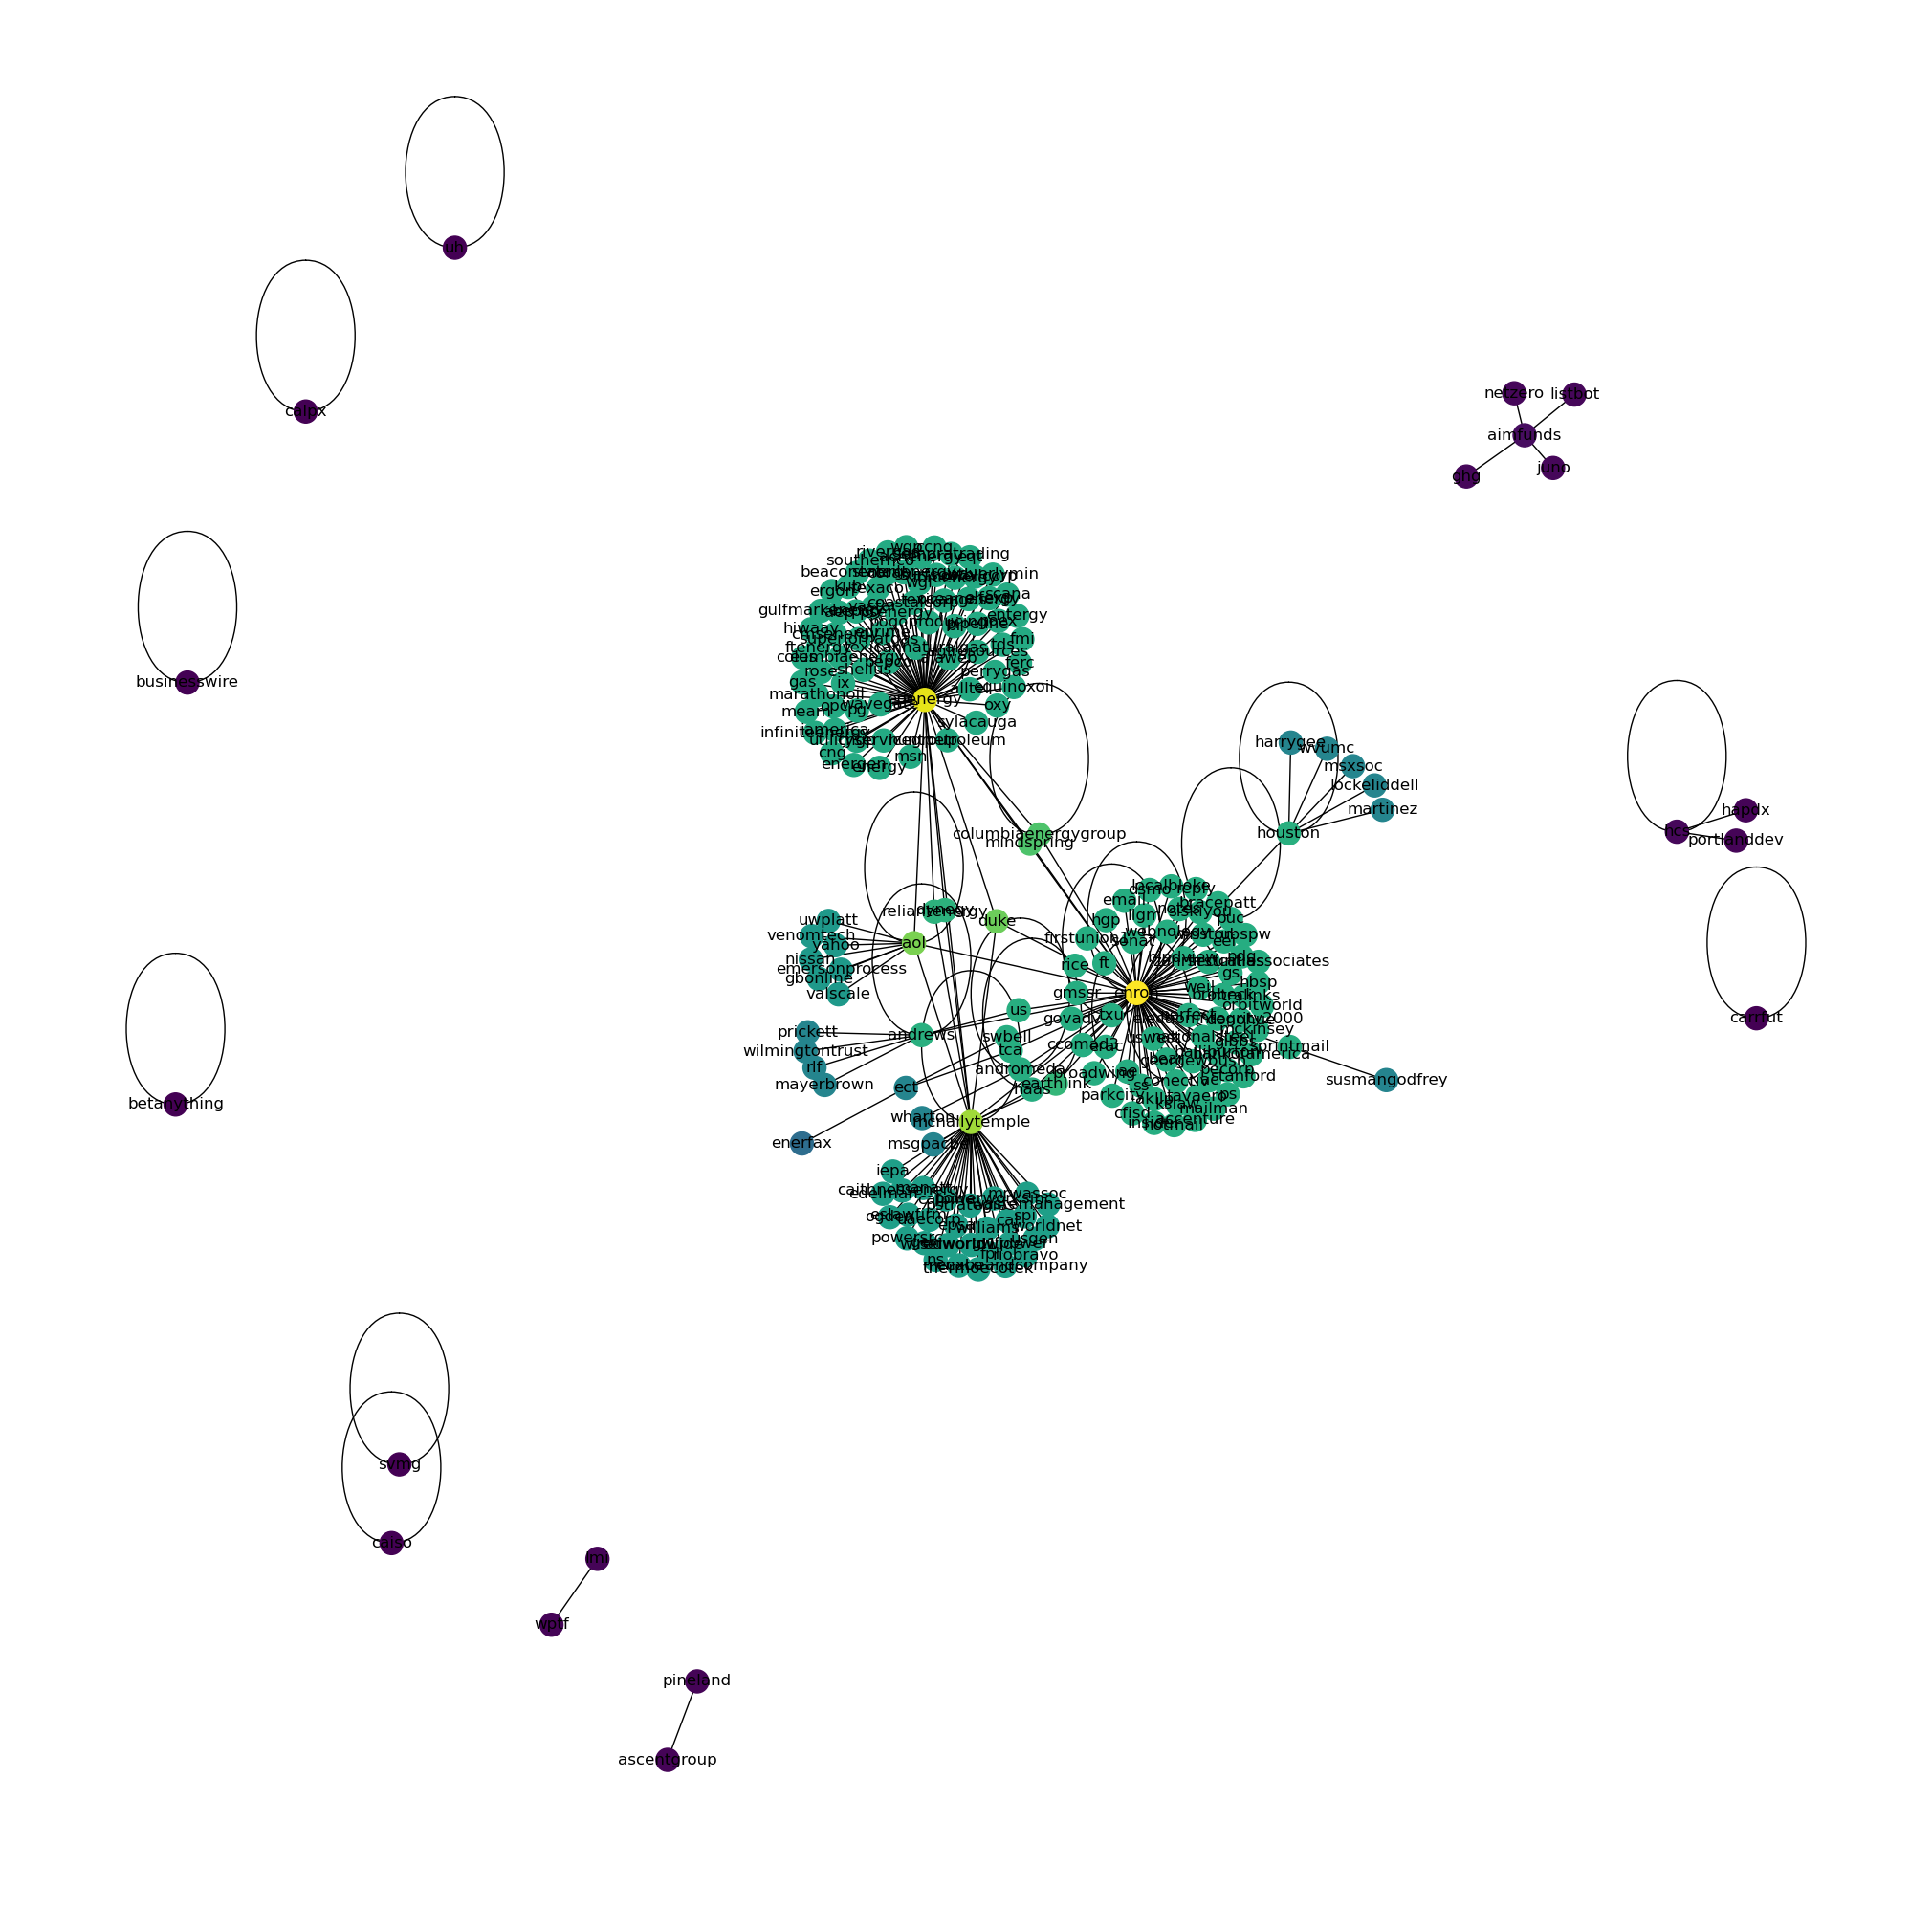

In [28]:
G2 = nx.from_pandas_edgelist(df_entities, "send", "receive")

closeness_G2 = nx.closeness_centrality(G2)
closeness_G2 = list(closeness_G2.values())

plt.figure(figsize = (20,20))
pos2 = nx.spring_layout(G2, k=.1)
nx.draw(G2, pos2, node_size = 300, node_color = closeness_G2,with_labels = True)
plt.show()

### Further work

There exists multiple variants of the **Enron** Dataset, some containing more information about the emails, such as attachement files (pictures, videos, ..etc).

And also a **Person of Interest** tag, which inidcates individuals who were implied in the scandal and therefore called into the courtroom. 

We can train a graph model on a propoportion of the graph, and use it to identify those potential POI. and even identify some suspicious emails sent from those POIs